In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchvision import datasets, transforms

from algebra.cliffordalgebra import CliffordAlgebra
from models.modules.gp import SteerableGeometricProductLayer
from models.modules.linear import MVLinear
from models.modules.mvlayernorm import MVLayerNorm
from models.modules.mvsilu import MVSiLU

mnist = datasets.MNIST('~/datasets/', transform=transforms.ToTensor(), download=True)
image = mnist[0][0]

In [2]:
ca = CliffordAlgebra((1., 1.))

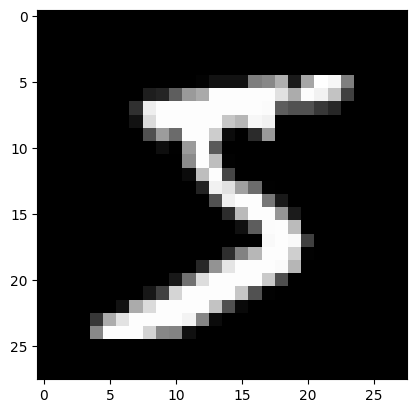

In [3]:
plt.imshow(image[0], cmap='gray')

In [4]:
class Bilinear(nn.Module):
    def __init__(self, dim = 1024):
        super().__init__()
        self.linear_1 = nn.Linear(dim, dim)
        self.linear_2 = nn.Linear(dim, dim)
        self.a = nn.Parameter(torch.zeros(dim))
        # self.linear_3 = nn.Linear(dim, dim)


    def forward(self, x):
        b = self.linear_2(x) / (torch.sigmoid(self.a[None])*(x.abs() - 1) + 1)
        return self.linear_1(x) * b + x


In [5]:
class MLP(nn.Module):
    def __init__(self, dim, hidden_dim = 1024):
        super(MLP, self).__init__()
        self.fc_in = nn.Linear(dim, hidden_dim)
        self.layers = nn.Sequential(
            *[
                nn.Linear(hidden_dim, hidden_dim),
            ] * 8
        )
        self.fc_out = nn.Sequential(nn.Linear(hidden_dim, 1))
        

    def forward(self, x):
        x = self.fc_in(x)
        x = F.gelu(x)
        for layer in self.layers:
            x = layer(x)
            x = F.gelu(x)
        x = self.fc_out(x)
        return x
    
mlp = MLP(2).cuda()
image_tensor = image.cuda()

adam = optim.Adam(mlp.parameters(), lr=1e-4)
ca = ca.cuda()

In [6]:
batch_size = 1
num_samples_per_batch = 1024

def reflective_sin_emb(x, dim):
    # For circular:
    # \left(-1\right)^{\operatorname{floor}\left(\frac{1-x}{2}\right)}\sin\left(\frac{\pi x}{2}\right)

    result = []
    for i in range(1, dim + 1, 2):
        result.append(torch.sin(i / 2 * torch.pi * x))
    return torch.stack(result, dim=-1)

i = 0 


# E = ca.geometric_product(
#     x_cl[:, None].repeat(1, len(Z_cl), 1),
#     Z_cl[None].repeat(len(x_cl), 1, 1)
# )[..., 0]

Z = torch.tensor([[1., 0.], [0., 1.]], device='cuda')
Z = Z[None, None].repeat(batch_size, num_samples_per_batch, 1, 1)
Z = ca.embed_grade(Z, 1)

while True:

    # random coordinates in [-1, 1]
    coordinates = torch.rand(batch_size, num_samples_per_batch, 2, device='cuda') * 2 - 1
    targets = F.grid_sample(image_tensor.unsqueeze(0), coordinates.unsqueeze(2), align_corners=True, mode='nearest')

    input = ca.geometric_product(
        ca.embed_grade(coordinates[:, :, None].repeat(1, 1, 2, 1), 1),
        Z,
    )

    input = input[..., 0]

    input = reflective_sin_emb(input, 1).squeeze(-1)

    input = input.view(batch_size * num_samples_per_batch, -1)

    output = mlp(input)

    loss = F.mse_loss(output.squeeze(), targets.squeeze())

    adam.zero_grad()
    loss.backward()
    adam.step()

    i += 1

    if i % 1 == 0:
        print(f'iteration {i}, loss: {loss.item()}')




iteration 1, loss: 0.12900707125663757
iteration 2, loss: 0.1298608034849167
iteration 3, loss: 0.12022249400615692
iteration 4, loss: 0.136681467294693
iteration 5, loss: 0.11217575520277023
iteration 6, loss: 0.12763985991477966
iteration 7, loss: 0.11779208481311798
iteration 8, loss: 0.12765495479106903
iteration 9, loss: 0.1193474680185318
iteration 10, loss: 0.10952045023441315
iteration 11, loss: 0.12183208763599396
iteration 12, loss: 0.12413575500249863
iteration 13, loss: 0.11320020258426666
iteration 14, loss: 0.10178356617689133
iteration 15, loss: 0.10334575176239014
iteration 16, loss: 0.09758631139993668
iteration 17, loss: 0.10520344972610474
iteration 18, loss: 0.10738173127174377
iteration 19, loss: 0.10190284252166748
iteration 20, loss: 0.10711434483528137
iteration 21, loss: 0.11133626103401184
iteration 22, loss: 0.11578452587127686
iteration 23, loss: 0.09713058173656464
iteration 24, loss: 0.10292993485927582
iteration 25, loss: 0.11298023164272308
iteration 26,

KeyboardInterrupt: 

In [20]:
import numpy as np

translate = (0, 0)
scale = 1

size = 28

size = int(size * scale)
repeats = 8

X = torch.linspace(-1, -1 + repeats * 2, size * repeats)
Y = torch.linspace(-1, -1 + repeats * 2, size * repeats)

X, Y = torch.meshgrid(X, Y, indexing='xy')
coordinates = torch.stack([X, Y], dim=-1).cuda()
coordinates = coordinates.view(-1, 2)

Z = torch.tensor([[1., 0.], [0., 1.]], device='cuda')
Z = Z[None].repeat(len(coordinates), 1, 1)
Z = ca.embed_grade(Z, 1)

input = ca.geometric_product(
    ca.embed_grade(coordinates[:, None].repeat(1, 2, 1), 1),
    Z,
)

input = input[..., 0]


input = reflective_sin_emb(input, 1).squeeze(-1)


with torch.no_grad():
    output = mlp(input)

output = output.view(size * repeats, size * repeats).cpu().numpy()


# canvas[base + translate[0]:base + size * repeats + translate[0], base + translate[1]:base + size * repeats + translate[1]] = output


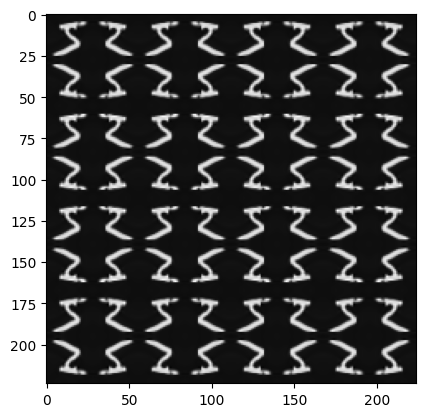

In [21]:
plt.imshow(output, cmap='gray')

In [22]:
bv = ca.random_grade(2)
bv = bv / ca.norm(bv)
# Rotate by 2pi / 8 
num_rotations = 128
R = ca.exponential(bv * torch.pi / num_rotations)

In [23]:
# evaluate the model on the meshgrid

images = []
for i in range(num_rotations + 1):

    with torch.no_grad():

        input = ca.geometric_product(
            ca.embed_grade(coordinates[:, None].repeat(1, 2, 1), 1),
            Z,
        )

        input = input[..., 0]

        input = reflective_sin_emb(input, 1).squeeze(-1)

        output = mlp(input)

    output = output.view(size * repeats, size * repeats).cpu()

    # output = output
    # B = (B - B.min()) / (B.max() - B.min())
    # print(B.max(), B.min())

    # img = (B[:, :, None].repeat(1, 1, 3) * 255).type(torch.uint8)
    # images.append(img.numpy())
    # z = ca.rho(R, z)

    output = (output - output.min()) / (output.max() - output.min())
    image = (output[:, :, None].repeat(1, 1, 3) * 255).type(torch.uint8)
    images.append(image)
    Z = ca.rho(R, Z)



In [24]:
import imageio

imageio.mimsave('movie.gif', images, format='GIF', fps=24, loop=0)


In [25]:
import numpy as np
from ipywidgets import interactive


base_canvas = np.zeros((1024, 1024))


def display_image(rot, tx, ty, scale, update):
    canvas = np.zeros((1024, 1024))

    R = ca.exponential(bv * rot)
    translate = (tx, ty)
    
    size = 28

    size = int(size * scale)
    repeats = 1

    base = (1024 - size * repeats) // 2
    X = torch.linspace(-1, -1 + repeats * 2, size * repeats)
    Y = torch.linspace(-1, -1 + repeats * 2, size * repeats)

    X, Y = torch.meshgrid(X, Y, indexing='xy')
    coordinates = torch.stack([X, Y], dim=-1).cuda()
    coordinates = coordinates.view(-1, 2)

    Z = torch.tensor([[1., 0.], [0., 1.]], device='cuda')
    Z = Z[None].repeat(len(coordinates), 1, 1)
    Z = ca.embed_grade(Z, 1)
    Z = ca.rho(R, Z)

    input = ca.geometric_product(
        ca.embed_grade(coordinates[:, None].repeat(1, 2, 1), 1),
        Z,
    )

    input = input[..., 0]


    input = reflective_sin_emb(input, 1).squeeze(-1)

    with torch.no_grad():
        output = mlp(input)

    output = output.view(size * repeats, size * repeats).cpu().numpy()

    canvas[base + translate[0]:base + size * repeats + translate[0], base + translate[1]:base + size * repeats + translate[1]] = output
    
    global base_canvas 

    canvas += base_canvas

    canvas = np.clip(canvas, 0, 1)

    plt.imshow(canvas, cmap='gray')
    plt.show()

    if update:
        base_canvas = canvas.copy()

interactive_plot = interactive(display_image, rot=(0, torch.pi, 0.1), tx=(-256, 256, 1), ty=(-256, 256, 1), scale=(0.1, 32, 0.1), update=False)


display(interactive_plot)


interactive(children=(FloatSlider(value=1.5, description='rot', max=3.141592653589793), IntSlider(value=0, des…